In [13]:
import pandas as pd
path = "C:/Users/bhagy/OneDrive/Desktop/Data Analytics Assignment.csv"
raw = pd.read_csv(path, encoding='utf-8')
raw.head(20)
raw.columns
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   0 non-null      float64
 1   Unnamed: 1   96 non-null     object 
 2   Unnamed: 2   93 non-null     object 
 3   Unnamed: 3   93 non-null     object 
 4   Unnamed: 4   93 non-null     object 
 5   Unnamed: 5   93 non-null     object 
 6   Unnamed: 6   93 non-null     object 
 7   Unnamed: 7   93 non-null     object 
 8   Unnamed: 8   93 non-null     object 
 9   Unnamed: 9   93 non-null     object 
 10  Unnamed: 10  93 non-null     object 
 11  Unnamed: 11  93 non-null     object 
dtypes: float64(1), object(11)
memory usage: 12.3+ KB


In [21]:
import pandas as pd
import io
import re

def parse_multi_section_csv(path):
    """
    Parses a CSV-like file that contains labeled sections like:
      'Total Data', 'Daily Data', 'Hourly Data'
    Each section has:
      - one header line (column names)
      - multiple data lines until a blank line or next section label
    
    Returns: dict of {section_name: pandas.DataFrame}
    """
    # Read all lines so we can iterate flexibly
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        raw_lines = f.readlines()
    
    # Normalize line endings and remove '\ufeff' BOM from first line if present
    raw_lines = [ln.rstrip('\n').rstrip('\r') for ln in raw_lines]
    if raw_lines and raw_lines[0].startswith('\ufeff'):
        raw_lines[0] = raw_lines[0].lstrip('\ufeff')
    
    sections_to_find = ['Total Data', 'Daily Data', 'Hourly Data']
    sections = {}  # store parsed content: {name: {'header': [...], 'rows': [[...], ...]}}
    
    i = 0
    n = len(raw_lines)
    # Iterate through lines
    while i < n:
        line = raw_lines[i]
        # If this line contains a section name, we start parsing that section
        matched = None
        for sec in sections_to_find:
            # Use exact match when ignoring leading/trailing commas/whitespace
            if sec in line:
                matched = sec
                break
        if not matched:
            i += 1
            continue
        
        # We found a section line (e.g., ",Daily Data,,,,,,,,,,")
        sec_name = matched
        # Move forward to find header: the first non-empty line after this section line
        j = i + 1
        while j < n and raw_lines[j].strip() == '':
            j += 1
        if j >= n:
            # No header found -> empty section
            sections[sec_name] = {'header': [], 'rows': []}
            i = j
            continue
        
        header_line = raw_lines[j]
        # Many files have leading commas; strip leading commas and whitespace
        header_line = header_line.lstrip(',').strip()
        
        # Split header by comma to get column names, and clean them
        header_cols = [c.strip() for c in header_line.split(',') if c.strip() != '']
        
        # Now collect rows until we hit a blank line or another section label
        data_rows = []
        k = j + 1
        while k < n:
            ln = raw_lines[k]
            # Stop collecting if it's a blank line
            if ln.strip() == '':
                break
            # Stop if the line starts a new section (Total/Daily/Hourly)
            if any(sec in ln for sec in sections_to_find):
                break
            # Remove leading commas and trailing spaces (some rows begin with commas)
            cleaned = ln.lstrip(',').strip()
            # If the line is empty after stripping, skip
            if cleaned == '':
                k += 1
                continue
            # Split into columns and strip spaces
            parts = [p.strip() for p in cleaned.split(',')]
            # If number of parts differs from headers, pad with empty strings (robustness)
            if len(parts) < len(header_cols):
                parts = parts + [''] * (len(header_cols) - len(parts))
            # If there are more parts than headers, keep all but warn (we can truncate or keep extras)
            if len(parts) > len(header_cols):
                # We'll keep extras by creating additional column names
                # but here we just truncate to header length (cleaner for expected well-formed CSV)
                parts = parts[:len(header_cols)]
            data_rows.append(parts)
            k += 1
        
        sections[sec_name] = {'header': header_cols, 'rows': data_rows}
        # Continue from k (the line after collected rows)
        i = k
    
    # Convert each section to DataFrame
    dfs = {}
    for sec_name, content in sections.items():
        cols = content['header']
        rows = content['rows']
        if not cols:
            dfs[sec_name] = pd.DataFrame()  # empty
            continue
        df = pd.DataFrame(rows, columns=cols)
        
        # Attempt numeric conversion for any column that looks numeric
        for c in df.columns:
            # Remove thousand separators or non-numeric characters if needed:
            # df[c] = df[c].str.replace(',', '')   # uncomment if thousands sep used
            df[c] = pd.to_numeric(df[c], errors='ignore')
            # Try date parsing (if the column name suggests date)
            if 'date' in c.lower() or 'hour' in c.lower():
                df[c] = pd.to_datetime(df[c], errors='coerce')
        
        dfs[sec_name] = df
    
    return dfs

# Usage
path = "C:/Users/bhagy/OneDrive/Desktop/Data Analytics Assignment.csv"   # replace with your path
dfs = parse_multi_section_csv(path)

# Show shapes and small preview
for name, df in dfs.items():
    print(name, df.shape)
    print(df.head(5))

Total Data (1, 11)
  Date  unique_idfas  unique_ips  unique_uas  total_requests  \
0  NaT       1191603     1189884          28         1770702   

   requests_per_idfa  impressions  impressions_per_idfa  idfa_ip_ratio  \
0           1.485983            0                     0       1.001445   

   idfa_ua_ratio       IVT  
0       42557.25  0.004276  
Daily Data (5, 11)
        Date  unique_idfas  unique_ips  unique_uas  total_requests  \
0 2025-09-11         93345       93340          22           99280   
1 2025-09-12        515646      515307          25          649515   
2 2025-09-13        406993      406729          25          473346   
3 2025-09-14        400917      400668          26          467152   
4 2025-09-15         76526       76519          21           81409   

   requests_per_idfa  impressions  impressions_per_idfa  idfa_ip_ratio  \
0           1.063581            0                     0       1.000054   
1           1.259614            0                     0  

C:\Users\bhagy\AppData\Local\Temp\ipykernel_26196\1518950705.py:110: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')
C:\Users\bhagy\AppData\Local\Temp\ipykernel_26196\1518950705.py:110: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')
C:\Users\bhagy\AppData\Local\Temp\ipykernel_26196\1518950705.py:110: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')
C:\Users\bhagy\AppData\Local\Temp\ipykernel_26196\1518950705.py:110: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric w

In [23]:
dfs["Total Data"]
dfs["Daily Data"]
dfs["Hourly Data"]

,Date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,IVT
0,2025-09-11 14:00:00,3535,3535,17,3577,1.011881,0,0,1.000000,207.941177,0.010695
1,2025-09-11 15:00:00,7254,7254,17,7361,1.014750,0,0,1.000000,426.705882,0.000000
2,2025-09-11 16:00:00,13737,13737,17,14073,1.024459,0,0,1.000000,808.058824,0.000000
3,2025-09-11 17:00:00,13800,13800,18,14074,1.019855,0,0,1.000000,766.666667,0.006250
4,2025-09-11 18:00:00,8696,8696,19,8796,1.011500,0,0,1.000000,457.684211,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
79,2025-09-14 21:00:00,11802,11802,17,11915,1.009575,0,0,1.000000,694.235294,0.004264
80,2025-09-14 22:00:00,13518,13518,17,13662,1.010652,0,0,1.000000,795.176471,0.001901
81,2025-09-14 23:00:00,42748,42746,20,44626,1.043932,0,0,1.000047,2137.400000,0.000000
82,2025-09-15 00:00:00,40618,40616,20,42359,1.042863,0,0,1.000049,2030.900000,0.005935


In [28]:
#Cleaning and verifying each DataFrame

for name, df in dfs.items():
    print(name, df.info())
    print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  0 non-null      datetime64[ns]
 1   unique_idfas          1 non-null      int64         
 2   unique_ips            1 non-null      int64         
 3   unique_uas            1 non-null      int64         
 4   total_requests        1 non-null      int64         
 5   requests_per_idfa     1 non-null      float64       
 6   impressions           1 non-null      int64         
 7   impressions_per_idfa  1 non-null      int64         
 8   idfa_ip_ratio         1 non-null      float64       
 9   idfa_ua_ratio         1 non-null      float64       
 10  IVT                   1 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int64(6)
memory usage: 220.0 bytes
Total Data None
  Date  unique_idfas  unique_ips  unique_uas  total_req

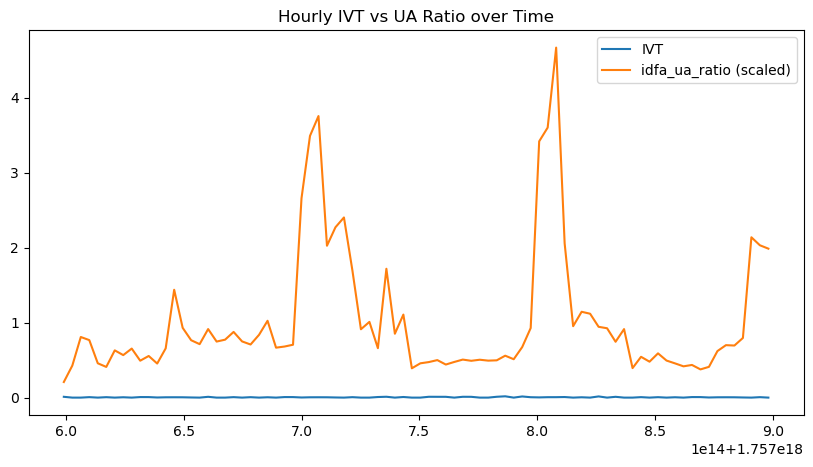

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(dfs["Hourly Data"]["Date"], dfs["Hourly Data"]["IVT"], label="IVT")
plt.plot(dfs["Hourly Data"]["Date"], dfs["Hourly Data"]["idfa_ua_ratio"]/1000, label="idfa_ua_ratio (scaled)")
plt.legend()
plt.title("Hourly IVT vs UA Ratio over Time")
plt.show()

In [82]:
#Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Plot defaults
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['lines.marker'] = 'o'

In [84]:
#Converting dates & numerics types

def convert_types_and_clean(df):
    # Detect date column
    df = df.copy()
    for c in df.columns:
        # strip spaces in strings
        if df[c].dtype == object:
            df[c] = df[c].str.strip()
    # Try parse date columns (columns containing 'date' or 'hour')
    for c in df.columns:
        if 'date' in c.lower() or 'hour' in c.lower():
            df[c] = pd.to_datetime(df[c], errors='coerce')
    # Convert numeric where possible
    for c in df.columns:
        # leave date types alone
        if np.issubdtype(df[c].dtype, np.datetime64):
            continue
        # convert numeric strings
        df[c] = pd.to_numeric(df[c].str.replace(',','') if df[c].dtype==object else df[c], errors='coerce')
    return df

for name in dfs:
    dfs[name] = convert_types_and_clean(dfs[name])
    print(name, dfs[name].dtypes)
    display(dfs[name].head())

Total Data Date                    datetime64[ns]
unique_idfas                     int64
unique_ips                       int64
unique_uas                       int64
total_requests                   int64
requests_per_idfa              float64
impressions                      int64
impressions_per_idfa             int64
idfa_ip_ratio                  float64
idfa_ua_ratio                  float64
IVT                            float64
dtype: object


,Date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,IVT
0,NaT,1191603,1189884,28,1770702,1.485983,0,0,1.001445,42557.25,0.004276


Daily Data Date                    datetime64[ns]
unique_idfas                     int64
unique_ips                       int64
unique_uas                       int64
total_requests                   int64
requests_per_idfa              float64
impressions                      int64
impressions_per_idfa             int64
idfa_ip_ratio                  float64
idfa_ua_ratio                  float64
IVT                            float64
dtype: object


,Date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,IVT
0,2025-09-11,93345,93340,22,99280,1.063581,0,0,1.000054,4242.954545,0.003456
1,2025-09-12,515646,515307,25,649515,1.259614,0,0,1.000658,20625.840000,0.003409
2,2025-09-13,406993,406729,25,473346,1.163032,0,0,1.000649,16279.720000,0.006033
3,2025-09-14,400917,400668,26,467152,1.165209,0,0,1.000621,15419.884620,0.003836
4,2025-09-15,76526,76519,21,81409,1.063808,0,0,1.000091,3644.095238,0.002968


Hourly Data Date                    datetime64[ns]
unique_idfas                     int64
unique_ips                       int64
unique_uas                       int64
total_requests                   int64
requests_per_idfa              float64
impressions                      int64
impressions_per_idfa             int64
idfa_ip_ratio                  float64
idfa_ua_ratio                  float64
IVT                            float64
dtype: object


,Date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,IVT
0,2025-09-11 14:00:00,3535,3535,17,3577,1.011881,0,0,1.0,207.941177,0.010695
1,2025-09-11 15:00:00,7254,7254,17,7361,1.014750,0,0,1.0,426.705882,0.000000
2,2025-09-11 16:00:00,13737,13737,17,14073,1.024459,0,0,1.0,808.058824,0.000000
3,2025-09-11 17:00:00,13800,13800,18,14074,1.019855,0,0,1.0,766.666667,0.006250
4,2025-09-11 18:00:00,8696,8696,19,8796,1.011500,0,0,1.0,457.684211,0.000000


In [86]:
#Save the parsed sections as CSVs for easier reuse
os.makedirs('parsed_sections', exist_ok=True)
for name, df in dfs.items():
    safe = name.replace(' ', '_').lower()
    out = os.path.join('parsed_sections', f'{safe}.csv')
    df.to_csv(out, index=False)
    print('Saved', out)


Saved parsed_sections\total_data.csv
Saved parsed_sections\daily_data.csv
Saved parsed_sections\hourly_data.csv


Hourly shape: (84, 11)


,count,mean,min,25%,50%,75%,max,std
Date,84,2025-09-13 07:29:59.999999744,2025-09-11 14:00:00,2025-09-12 10:45:00,2025-09-13 07:30:00,2025-09-14 04:15:00,2025-09-15 01:00:00,NaN
unique_idfas,84.0,20183.25,3535.0,9070.5,13456.0,19594.5,97985.0,18780.855258
unique_ips,84.0,20182.154762,3535.0,9070.5,13456.0,19593.5,97975.0,18779.530981
unique_uas,84.0,19.071429,17.0,18.0,19.0,20.0,23.0,1.511289
total_requests,84.0,21079.785714,3577.0,9429.5,13685.0,20199.25,105699.0,20235.105032
requests_per_idfa,84.0,1.031473,1.004514,1.013207,1.025351,1.043306,1.094835,0.022219
impressions,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
impressions_per_idfa,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
idfa_ip_ratio,84.0,1.000043,1.0,1.0,1.0,1.000068,1.000334,0.000068
idfa_ua_ratio,84.0,1024.944673,207.941177,496.320433,706.497494,966.541667,4665.952381,876.215068


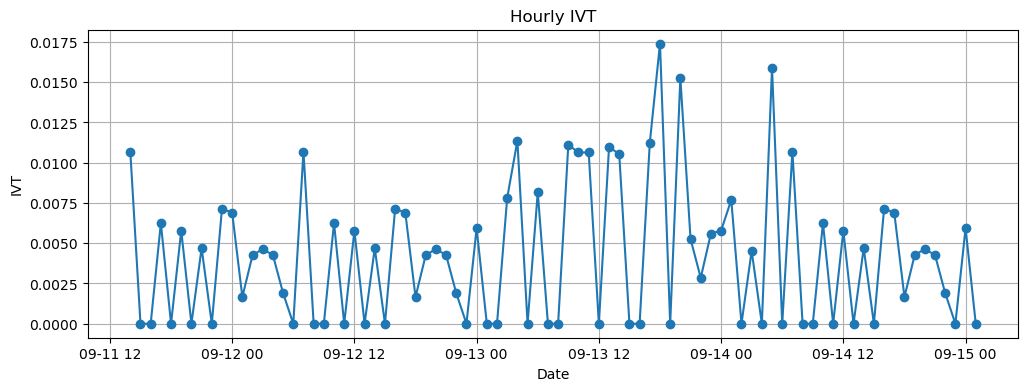

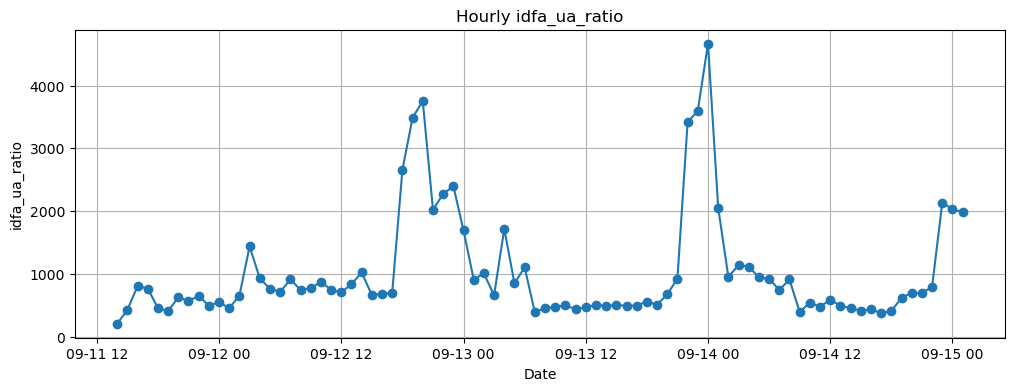

In [88]:
#Basic EDA for the Hourly section
hourly = dfs.get('Hourly Data')
if hourly is None:
    hourly = dfs.get('Hourly_Data')
if hourly is None:
    hourly = dfs.get('Hourly')
    
print('Hourly shape:', hourly.shape)
display(hourly.describe(include='all').transpose())

# Plot IVT and idfa_ua_ratio over time
plt.figure()
plt.plot(hourly['Date'], hourly['IVT'], label='IVT')
plt.title('Hourly IVT')
plt.xlabel('Date')
plt.ylabel('IVT')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(hourly['Date'], hourly['idfa_ua_ratio'], label='idfa_ua_ratio')
plt.title('Hourly idfa_ua_ratio')
plt.xlabel('Date')
plt.ylabel('idfa_ua_ratio')
plt.grid(True)
plt.show()